# CIFAR-10 GAN
This GAN will generate images of a ship

## Importing libraries

In [23]:
from tensorflow import keras
from keras.datasets.cifar10 import load_data
from keras.models import Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Reshape, Flatten, Input, Dropout
from keras.preprocessing import image
from keras.activations import tanh
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

## Loading the dataset

In [24]:
(x_train, y_train) , (_, _) = load_data()
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


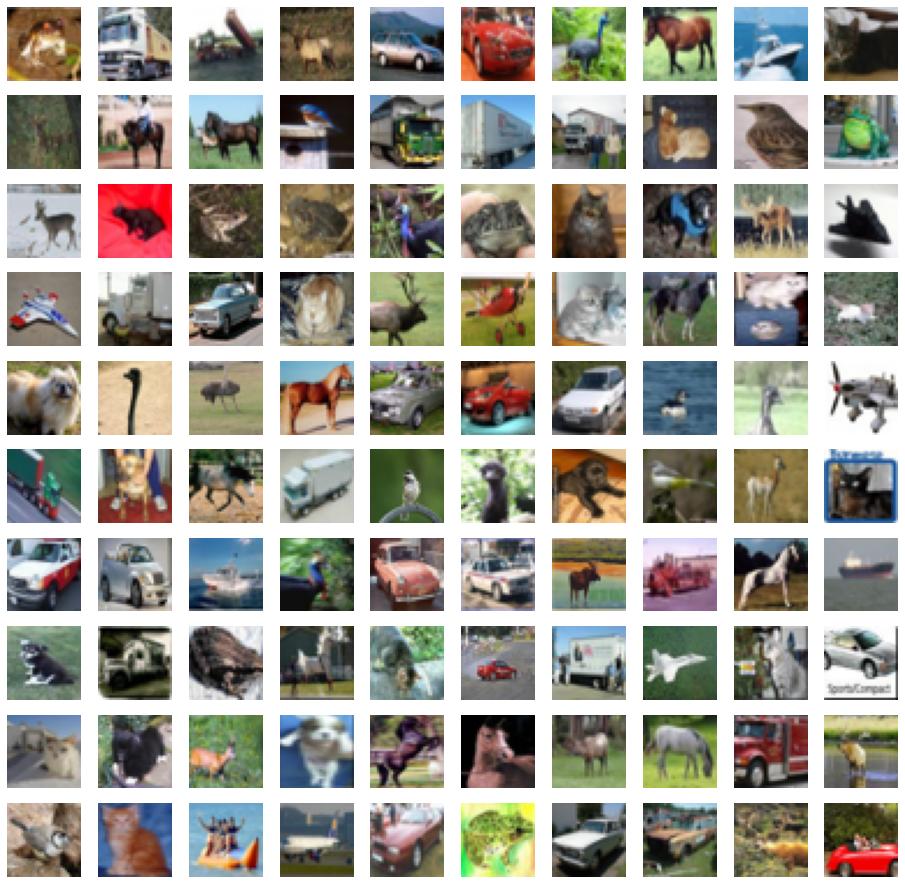

In [25]:
plt.figure(figsize= (16, 16))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()

## The Generator

In [26]:
latent_dim = 32
hieght = 32
width = 32
channels = 3

generator_input = Input(shape= (latent_dim, ))

x = Dense(128*16*16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

x = Conv2D(256, 5, padding= 'same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, strides=2, padding= 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding= 'same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding= 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation= 'tanh', padding= 'same')(x)
generator = Model(generator_input, x)
generator.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)     

## The Discriminator

In [27]:
discriminator_input = Input(shape= (hieght, width, channels))

x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)

x = Conv2D(128, 4, strides= (2, 2))(x)
x = LeakyReLU()(x)

x = Conv2D(128, 4, strides= (2, 2))(x)
x = LeakyReLU()(x)

x = Conv2D(128, 4, strides= (2, 2))(x)
x = LeakyReLU()(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation= 'sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 6, 6, 128)       

In [28]:
discriminator_opt = Adam(learning_rate= 0.0008, clipvalue= 1.0, decay= 1e-8)
discriminator.compile(optimizer= discriminator_opt, metrics = ['accuracy'], loss = 'binary_crossentropy')

## Setting up network

In [29]:
discriminator.trainable = False
gan_input = Input(shape= (latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan_opt = Adam(lr = 0.0004, clipvalue = 1.0, decay= 1e-8)
gan.compile(optimizer= gan_opt, loss = 'binary_crossentropy')
gan.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
functional_19 (Functional)   (None, 32, 32, 3)         6264579   
_________________________________________________________________
functional_21 (Functional)   (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


## Training the GAN

In [30]:
x_train = x_train[y_train.flatten() == 8] # 8 = class index of ship
# Normalizing data
x_train = x_train.reshape((x_train.shape[0], ) + (hieght, width, channels)).astype('float32')/255.0

iterations = 10000
batch_size = 20
save_dir = 'saved_images'

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim)) # samples random points in latent space
    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))]) # assembles labels discriminating real from fake images
    labels += 0.05 * np.random.random(labels.shape) # adds random noise to the labels THIS IS IMPORTANT

    d_loss = discriminator.train_on_batch(combined_images, labels) # discriminator loss

    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim)) # again samples random points in latent space
    
    misleading_targets = np.zeros((batch_size, 1)) # assembles labels saying the image is real (although its fake)

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) # adversarial loss

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        print('Discriminator Loss: ', d_loss)
        print('Adversarial Loss: ', a_loss)
        img = image.array_to_img(generated_images[0] * 255.0, scale=False)
        img.save(os.path.join(save_dir, 'generated_ship' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255.0, scale=False)
        img.save(os.path.join(save_dir, 'real_ship' + str(step) + '.png'))


Discriminator Loss:  [0.676565945148468, 0.0]
Adversarial Loss:  0.6959509253501892
Discriminator Loss:  [63.072784423828125, 0.0]
Adversarial Loss:  9.880719184875488
Discriminator Loss:  [0.2947384715080261, 0.0]
Adversarial Loss:  40.077999114990234
Discriminator Loss:  [0.5279043316841125, 0.0]
Adversarial Loss:  61.4814567565918
Discriminator Loss:  [-0.07269419729709625, 0.0]
Adversarial Loss:  52.78643798828125
Discriminator Loss:  [11.839120864868164, 0.0]
Adversarial Loss:  1020.5499267578125
Discriminator Loss:  [0.12761861085891724, 0.0]
Adversarial Loss:  33.55796813964844
Discriminator Loss:  [-1.2125036716461182, 0.0]
Adversarial Loss:  171.7256622314453
Discriminator Loss:  [2.6735541820526123, 0.0]
Adversarial Loss:  1051.281982421875
Discriminator Loss:  [100.74665832519531, 0.0]
Adversarial Loss:  15686.470703125
Discriminator Loss:  [-495.6698303222656, 0.0]
Adversarial Loss:  39978.4296875
Discriminator Loss:  [-7135.16552734375, 0.0]
Adversarial Loss:  859235.375
D